# Импорт библиотек

In [93]:
from sklearn.datasets import make_moons, make_circles

import torch
from torch import nn
from torch import optim
from torch.distributions import MultivariateNormal, Normal

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [94]:
N_SAMPLES = 1_500

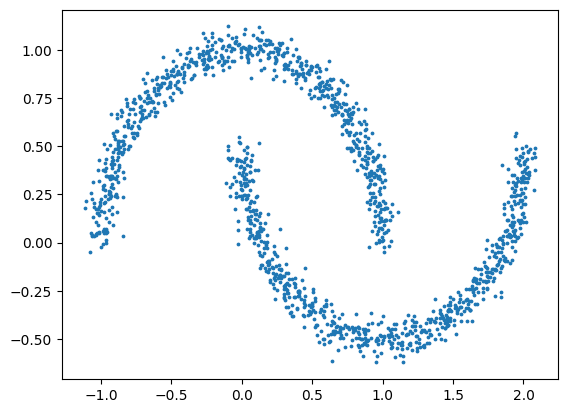

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [95]:
moons = torch.tensor(make_moons(N_SAMPLES, noise=0.05)[0], dtype=torch.float32)
plt.scatter(moons[:, 0], moons[:, 1], s=3)
plt.show()
moons.shape
moons = moons.to('cuda')
moons.dtype

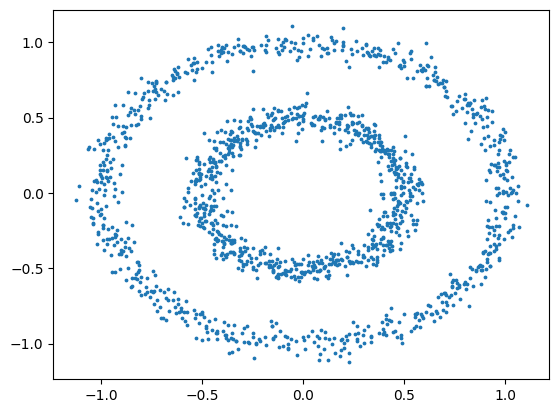

(1500, 2)

In [ ]:
circles = make_circles(N_SAMPLES, noise=0.05, factor=0.5)[0]
plt.scatter(circles[:, 0], circles[:, 1], s=3)
plt.show()
circles.shape

In [ ]:
normal = MultivariateNormal(torch.zeros(2).to('cuda'), torch.eye(2).to('cuda'))
norm_samples = normal.sample([N_SAMPLES])
# plt.scatter(norm_samples[:, 0], norm_samples[:, 1], s=3)
# plt.show()

norm_samples.dtype

torch.float32

In [ ]:
normal_1 = Normal(5, 1)
norm_1 = normal_1.sample([N_SAMPLES])

normal_2 = Normal(-2, 2)
norm_2 = normal_2.sample([N_SAMPLES])

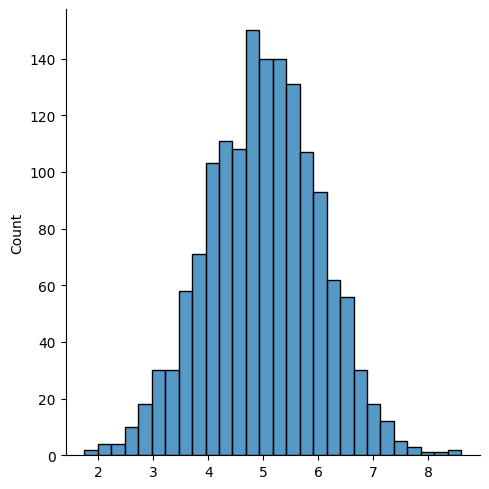

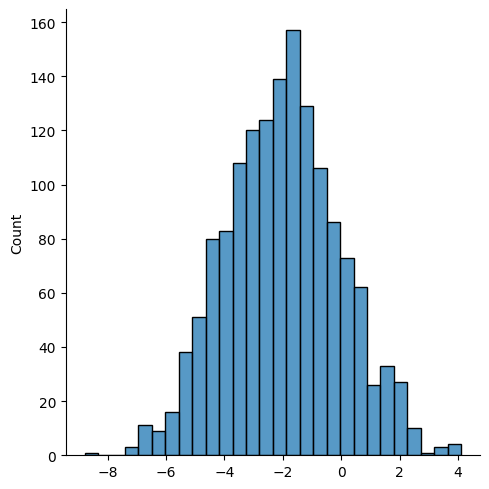

In [ ]:
sns.displot(norm_1)
sns.displot(norm_2)

norm_1 = norm_1.to('cuda')
norm_2 = norm_2.to('cuda')

## Algorithm
Заданной динамикой построить другую которая будет ограничена
Let we have dataset $\{y_j\}_{j=1}^m \forall y_j\in\mathbb{R}^2$ and we have latent distribution $\pi_0(x) = \mathcal{N}(0, I_2)$

$$
  \beta^* = \arg\max_\beta\frac1n\sum_{i=1}^n\log(\phi_1(y_i, \beta)) - \frac1{\tilde n \tilde m}\sum_{i}^{\tilde n}\sum_{j}^{\tilde m}\phi_1(\tilde y_j^i, \beta)\frac{\hat\phi_0(\tilde x_i, \alpha)}{\tilde\pi_0(\tilde x_i)},
$$
where $\tilde\pi_0(x)$ - some kind of KDE of dataset,<br>
$\tilde x_i \sim \pi_0(x)$ $\forall i\in\overline{1,\tilde n}$, <br>
$\tilde y_j^i \sim p(y|\tilde x_i)$ $\forall i\in\overline{1,\tilde n}$ $\forall j\in\overline{1,\tilde m}$, <br>
$n$ - number of smaples from $\pi_0(x)$

$$
  \alpha^* = \arg\max_\alpha\frac1m\sum_{j=1}^m\log(\hat\phi_0(x_j, \alpha)) - \frac1{\tilde n \tilde m}\sum_{i}^{\tilde n}\sum_{j}^{\tilde m}\phi_1(\tilde y_j^i, \beta)\frac{\hat\phi_0(\tilde x_i, \alpha)}{\tilde\pi_0(\tilde x_i)},
$$
where $\tilde\pi_0(x)$ - some kind of KDE of dataset,<br>
$\tilde x_i \sim \pi_0(x)$ $\forall i\in\overline{1,\tilde n}$, <br>
$\tilde y_j^i \sim p(y|\tilde x_i)$ $\forall i\in\overline{1,\tilde n}$ $\forall j\in\overline{1,\tilde m}$, <br>
$n$ - number of smaples from $\pi_0(x)$<br>

Now we have two functions $\phi_1(y, \beta^*), \hat\phi_0(x, \alpha^*)$ which can be used to calculate joint distribution $q^*(x, y)$<r>

To generata data $y$ we use
<!-- q(y|x) = \frac{q^*(x, y)}{\pi_0(x)} = \frac{\phi_1(y, \beta^*) p(y|x) \hat\phi_0(x, \alpha^*)}{\pi_0(x)}  -->
$$
\pi^*_1(y) = \phi_1(y_j, \beta^*)\hat\phi_1(y)
$$
<br>
$$
q(y|x) = \frac{q^*(x, y)}{\pi_0(x)} = \frac{\phi_1(y, \beta^*) p(y|x) \hat\phi_0(x, \alpha^*)}{\pi_0(x)}
$$



## Model
We will parametrize $\phi_1(y, \beta), \hat\phi_0(x, \alpha)$ with One-Layer NN with ReLU activation and 64 output size.

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(1, 32),
      nn.ReLU(),
      nn.Linear(32, 1),
      nn.Softplus()
    )

  def forward(self, x):
    x = x[:, None]
    return self.layers(x)

In [ ]:
EPOCHS = 250
INNER_STEP = 150

phi_0 = MLP()
phi_1 = MLP()

phi_0.to('cuda')
phi_1.to('cuda')

# Prior conditional  distribution p(y|x_s) = Normal(y | x_s, gamma*I)
# for sample in norm_samples:
gamma = 1000
y_x = Normal(norm_1, gamma * 1).sample([400]).to('cuda')

optimizer_forward = optim.Adam(phi_0.parameters(), lr=0.001)
optimizer_backward = optim.Adam(phi_1.parameters(), lr=0.001)

In [ ]:
losses = {
    'forward': [],
    'backward': []
}

samples_probs = normal_1.log_prob(norm_1).exp()[:, None]

for i in tqdm(range(EPOCHS)):
    temp_loss = 0
    for j in range(INNER_STEP):
        optimizer_forward.zero_grad()
        output = phi_0(norm_1)
        model_log = output.log().mean(dim=0)
        constraint = (phi_1(y_x.reshape(-1, 1)).reshape(400, -1, 1).mean(dim=0) * output / samples_probs).mean(dim=0)

        loss_forward =  -(model_log - constraint).mean()
        temp_loss += loss_forward.cpu().detach().numpy()
        loss_forward.backward()
        optimizer_forward.step()
    losses['forward'].append(temp_loss/INNER_STEP)

    temp_loss = 0
    for j in range(INNER_STEP):
        optimizer_backward.zero_grad()
        model_log = phi_1(norm_2).log().mean(dim=0)
        constraint = (phi_1(y_x.reshape(-1, 1)).reshape(400, -1, 1).mean(dim=0) * phi_0(norm_1) / samples_probs).mean(dim=0)

        loss_backward = -(model_log - constraint).mean()
        temp_loss += loss_forward.cpu().detach().numpy()
        loss_backward.backward()
        optimizer_backward.step()
    losses['backward'].append(temp_loss/INNER_STEP)


100%|██████████| 250/250 [06:17<00:00,  1.51s/it]


In [ ]:
losses

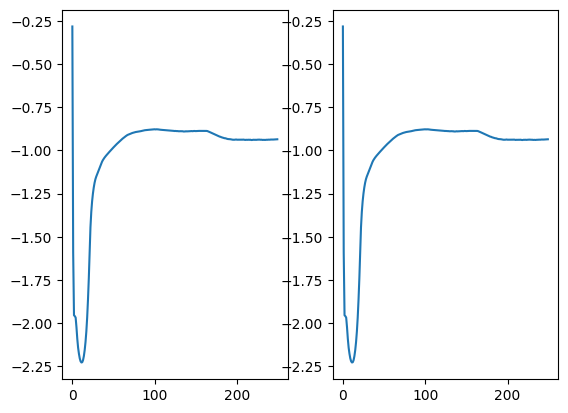

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(losses['forward'])
ax[1].plot(losses['forward'])

plt.show()

In [ ]:
phi_0.cpu()
phi_1.cpu()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

In [ ]:
phi_1(normal_1.sample([400])).mean(0)[:, None].shape

torch.Size([1, 1])

In [ ]:
test_samples_1 = normal_1.sample([1000])
test_samples_2 = normal_2.sample([1000])

test_probs = (phi_0(test_samples_1) * phi_1(test_samples_2)).detach().numpy().squeeze()


(torch.Size([1000]), (1000,))

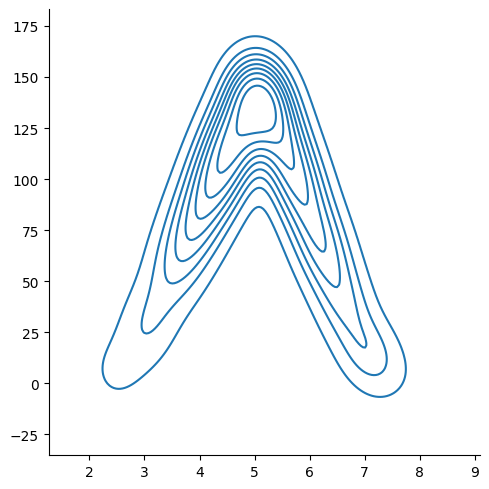

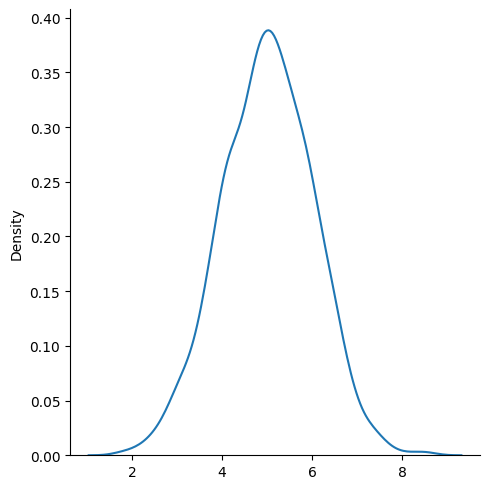

In [ ]:
sns.displot(x=test_samples, y=test_probs, kind='kde')
sns.displot(norm_1.cpu(), kind='kde')